# SARIMAX Model (No pmdarima)

In [7]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error




In [8]:
# Load dataset - replace path if needed
df = pd.read_csv("weatherHistory.csv")

# Parse the 'Formatted Date' properly
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True, errors='coerce')

# Set as index
df = df.set_index('Formatted Date')

# Now select features and resample
df = df[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
         'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']].resample('D').mean().dropna().ffill().asfreq('D')

print("Data range:", df.index.min(), "to", df.index.max())
df.head()



Data range: 2005-12-31 00:00:00+00:00 to 2016-12-31 00:00:00+00:00


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,
2005-12-31 00:00:00+00:00,0.577778,-4.050000,0.890000,17.114300,9.982000,1016.660000
2006-01-01 00:00:00+00:00,4.075000,-0.174537,0.817083,21.229192,11.348487,1011.985000
2006-01-02 00:00:00+00:00,5.263194,1.808796,0.847083,17.824713,8.492079,1010.384167
2006-01-03 00:00:00+00:00,2.340509,0.445370,0.897083,7.726658,9.223958,1021.170833
2006-01-04 00:00:00+00:00,2.251852,-0.663194,0.906667,12.152817,8.352546,981.770833


## EDA: seasonal decomposition and stationarity

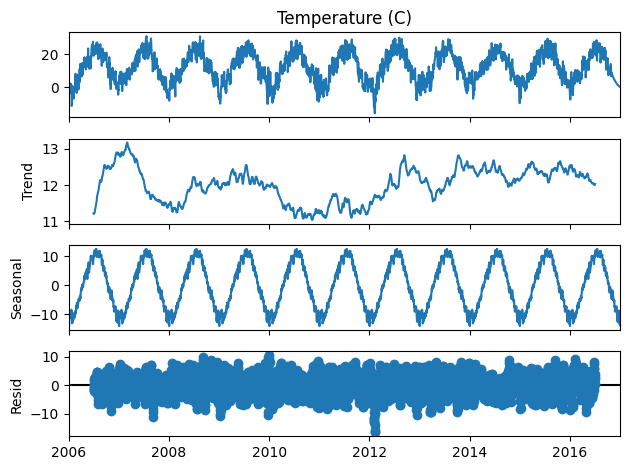

ADF p-value: 0.001461470004492821


In [9]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

series = df['Temperature (C)'].dropna()
res = seasonal_decompose(series, model='additive', period=365)
res.plot()
plt.show()

adf_res = adfuller(series)
print("ADF p-value:", adf_res[1])


## Train/test split and exogenous vars

In [10]:

target = df['Temperature (C)']
exog = df[['Humidity','Pressure (millibars)']].fillna(method='ffill')

train_target = train_target[-3*365:]

test_target = target[-365:]
train_exog = train_exog[-3*365:]
test_exog = exog[-365:]


C:\Users\Ruchir Mangal\AppData\Local\Temp\ipykernel_30272\2672537012.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog = df[['Humidity','Pressure (millibars)']].fillna(method='ffill')


## Fit SARIMAX (fixed orders)

In [11]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (2,1,2)
seasonal_order = (1,1,1,30)

model = SARIMAX(train_target, order=order, seasonal_order=seasonal_order, exog=train_exog,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False, low_memory=True, simple_differencing=True)

print(res.summary())


c:\New folder (2)\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: simple_differencing. After release 0.14, this will raise.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                      Temperature (C)   No. Observations:                 1095
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 30)   Log Likelihood               -2128.217
Date:                              Sun, 07 Sep 2025   AIC                           4274.433
Time:                                      22:20:48   BIC                           4318.878
Sample:                                  01-02-2013   HQIC                          4291.300
                                       - 01-01-2016                                         
Covariance Type:                             approx                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Humidity                -9.3766      0.708    -13.239      0.000     -10.765  

## Forecast and evaluate

MAE: 12.856, RMSE: 14.767, MAPE: 163.66%


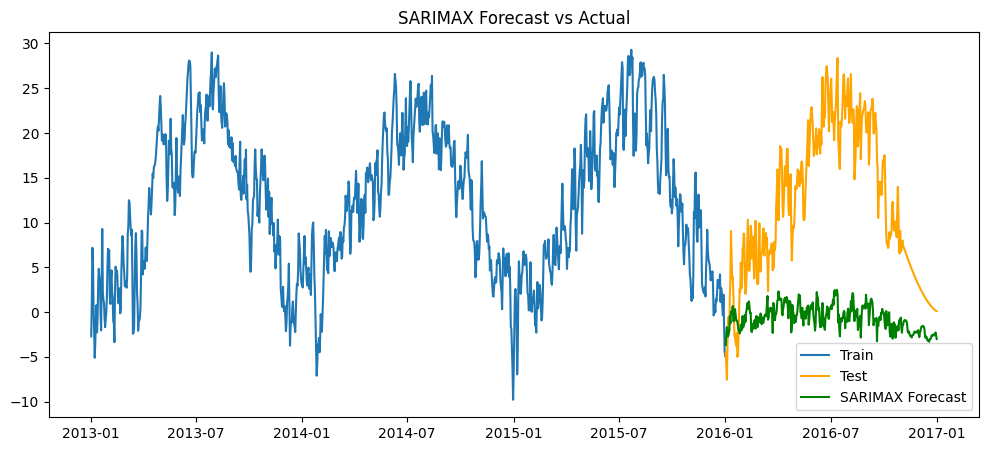

In [12]:

forecast_obj = res.get_forecast(steps=len(test_target), exog=test_exog)
mean_forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

mae = mean_absolute_error(test_target, mean_forecast)
rmse = np.sqrt(mean_squared_error(test_target, mean_forecast))
mape = np.mean(np.abs((test_target - mean_forecast) / test_target)) * 100
print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%")

plt.figure(figsize=(12,5))
plt.plot(train_target.index, train_target, label='Train')
plt.plot(test_target.index, test_target, label='Test', color='orange')
plt.plot(mean_forecast.index, mean_forecast, label='SARIMAX Forecast', color='green')
plt.fill_between(mean_forecast.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='gray', alpha=0.3)
plt.legend(); plt.title('SARIMAX Forecast vs Actual'); plt.show()


## Residual diagnostics

      lb_stat  lb_pvalue
10  20.799181   0.022538
20  34.409976   0.023481


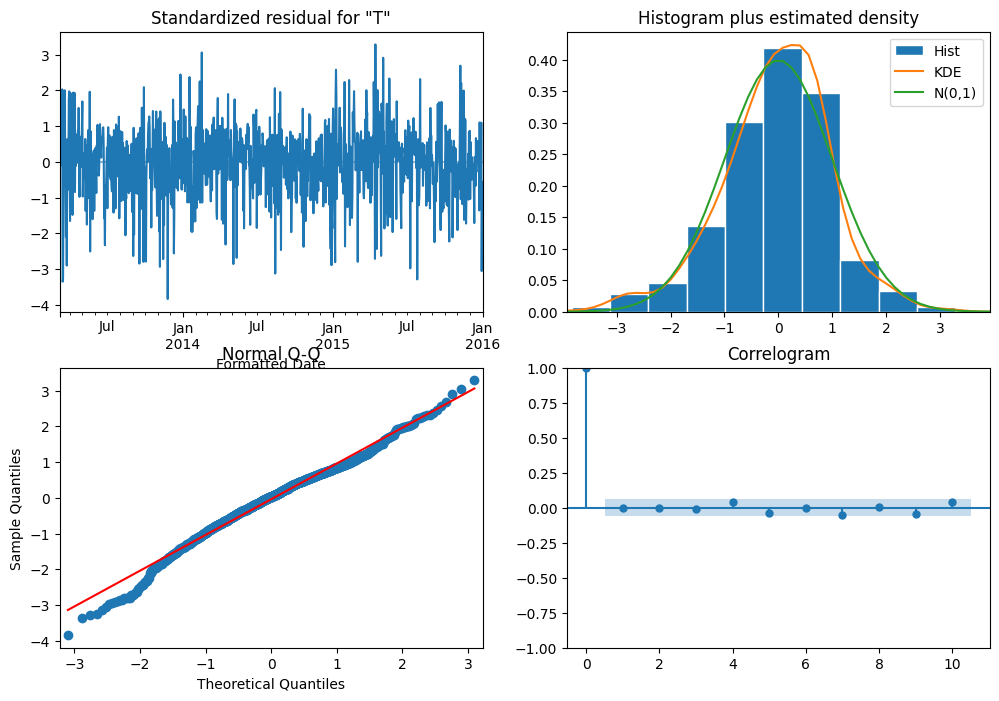

In [13]:

res.plot_diagnostics(figsize=(12,8))

from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(res.resid, lags=[10,20], return_df=True)
print(lb)


## Save model

In [14]:

import pickle
with open("sarimax_model.pkl", "wb") as f:
    pickle.dump(res, f)
print("Model saved as sarimax_model.pkl")


Model saved as sarimax_model.pkl
